## Background

Objective: To study regression splines and its implementation.

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# read data_set
data = pd.read_csv('data/wage.csv')

data.head()

,ID,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


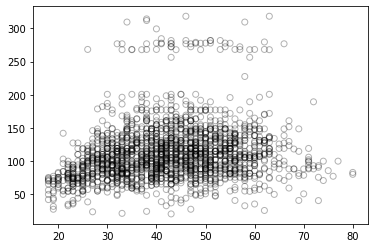

In [3]:
data_x = data['age']
data_y = data['wage']

# Dividing data into train and validation datasets
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=0.33, random_state = 1)

# Visualize the relationship b/w age and wage
plt.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.show()

## Linear Regression

Advantages: 

1. Relatively simple to implement.
2. Relatively advantages over other approaches in terms of interpretation and inference.

Disadvantages:

1. Significant limitations in terms of predictive power because the linear combination between the dependent and independent variables has to be assumed, which could be unrealistic in most cases.

In [4]:
# Fitting linear regression model
train_x_arr = train_x.values.reshape(-1,1)
model = LinearRegression()
model.fit(train_x_arr,train_y)
print(model.coef_)
print(model.intercept_)

[0.72190831]
80.65287740759283


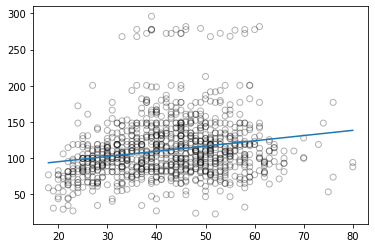

In [5]:
# Prediction on validation dataset
valid_x_arr = valid_x.values.reshape(-1,1)
pred = model.predict(valid_x_arr)

# Visualisation
# We will use 70 plots between minimum and maximum values of valid_x for plotting
xp = np.linspace(valid_x_arr.min(),valid_x_arr.max(),70)
xp = xp.reshape(-1,1)
pred_plot = model.predict(xp)

plt.scatter(valid_x_arr, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

In [6]:
rms = sqrt(mean_squared_error(valid_y, pred))
print(rms)

40.436687488017256


## 1. Improvement over Linear Regression: Polynomial Regression

The standard method to extend linear regression to a non-linear relationship between the dependent and independent variables, has been to replace the linear model with a polynomial function.

Disadvantages:

1. Could easily lead to over-fitting.
2. As the complexity of the formula has been increased, the number of features also increases which is sometimes difficult to handle.
3. Non-local inherently, i.e., changing the value of Y at one point in the training set can affect the fit of the polynomial for data points that are very far away.

[ -0.05194765   5.22868974 -10.03406116]


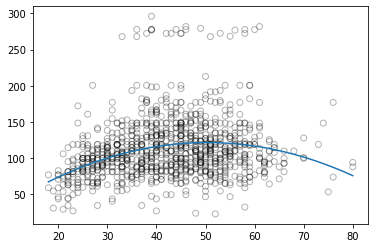

In [7]:
# Generating weights for polynomial function with degree=2
weights = np.polyfit(train_x, train_y, 2)
print(weights)

# Generating model with the given weights
model = np.poly1d(weights)

# Prediction on validation set
pred = model(valid_x)
# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred_plot = model(xp)
plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

## 2. Improvement over Linear Regression: Regression Splines

In Regression Splines, instead of building one model for the entire dataset, the dataset is divided into multiple bins and fits each bin with a linear or low degree polynomial function.

The points where the division occurs are called Knots. Functions which we can use for modelling each piece/bin are known as Piecewise functions. 

### Piecewise Step Functions

Disadvantage:

1. Binned regression does not create continuous functions of the predictor, so in most cases we would expect no relationship between the input and output. For example, in the example below, we can see that the first bin clearly misses the increasing trend of wage with age.

In [8]:
# Dividing the data into 4 bins
df_cut, bins = pd.cut(train_x, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]    504
(33.5, 49.0]      941
(49.0, 64.5]      511
(64.5, 80.0]       54
Name: age, dtype: int64

In [9]:
df_steps = pd.concat([train_x, df_cut, train_y], keys=['age','age_cuts','wage'], axis=1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_cut)
df_steps_dummies.columns = ['17.938-33.5','33.5-49','49-64.5','64.5-80'] 

df_steps_dummies.head()

,17.938-33.5,33.5-49,49-64.5,64.5-80
1382,0,1,0,0
23,0,1,0,0
2140,0,0,1,0
1117,1,0,0,0
933,0,1,0,0


In [10]:
# Fitting Generalised linear models
fit3 = sm.GLM(endog=df_steps.wage, exog=df_steps_dummies).fit()

# Binning validation set into same 4 bins
bin_mapping = np.digitize(x=valid_x, bins=bins) 

# Removing any outliers
X_valid = pd.get_dummies(bin_mapping).drop([5], axis=1)

# Prediction
pred2 = fit3.predict(X_valid)

# Calculating RMSE
rms = sqrt(mean_squared_error(valid_y, pred2)) 
print(rms)

39.990600783110395


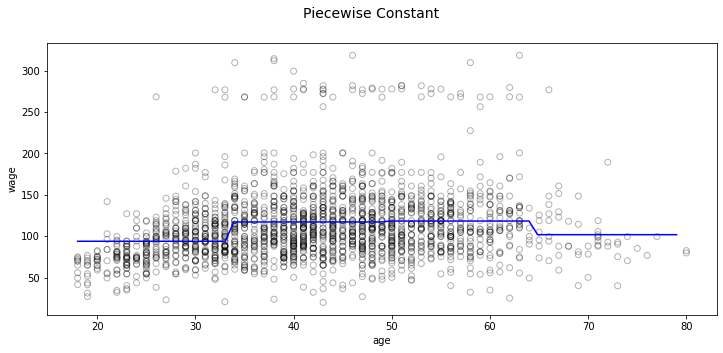

In [11]:
# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max()-1,70) 
bin_mapping = np.digitize(xp, bins) 
X_valid_2 = pd.get_dummies(bin_mapping) 
pred2 = fit3.predict(X_valid_2)

# Visualisation
fig, (ax1) = plt.subplots(1,1, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(xp, pred2, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
plt.show()

## Basis Functions

This concept of a family of transformations that can fit together to capture general shapes is called a basis function. The common choice for a basis function is Piecewise Polynomials.

### Piecewise Polynomials

Instead of fitting a constant function over different bins across the range of X (like Piecewise Step Functions did), piecewise polynomial regression involves fitting separate low-degree polynomials over different regions of X. 

Advantage:

1. As we use lower degrees of polynomials, we don’t observe high oscillations of the curve around the data.

### Cubic Splines

Cubic spline is a piecewise polynomial with a set of extra constraints (continuity, continuity of the first derivative, and continuity of the second derivative). In general, a cubic spline with K knots uses cubic spline with a total of 4 + K degrees of freedom. There is seldom any good reason to go beyond cubic-splines (unless one is interested in smooth derivatives).

In [12]:
# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix("bs(train, knots=(25,40,60), degree=3, include_intercept=False)", {"train": train_x},return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit1 = sm.GLM(train_y, transformed_x).fit()

# Generating cubic spline with 4 knots
transformed_x2 = dmatrix("bs(train, knots=(25,40,50,65), degree=3, include_intercept=False)", {"train": train_x}, return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit2 = sm.GLM(train_y, transformed_x2).fit()

# Predictions on both splines
pred1 = fit1.predict(dmatrix("bs(valid, knots=(25,40,60), degree=3, include_intercept=False)", {"valid": valid_x}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(valid, knots=(25,40,50,65), degree=3, include_intercept=False)", {"valid": valid_x}, return_type='dataframe'))

# Calculating RMSE values
rms1 = sqrt(mean_squared_error(valid_y, pred1))
print(rms1)

rms2 = sqrt(mean_squared_error(valid_y, pred2))
print(rms2)

39.403187683411254
39.34292609147628


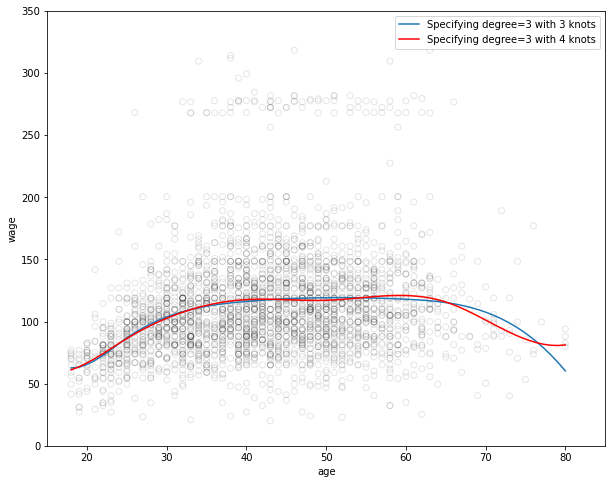

In [13]:
# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(xp, knots=(25,40,60), degree=3, include_intercept=False)", {"xp": xp}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(xp, knots=(25,40,50,65), degree=3, include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# Plot the splines and error bands
plt.figure(figsize=(10, 8))
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred1, label='Specifying degree=3 with 3 knots')
plt.plot(xp, pred2, color='r', label='Specifying degree=3 with 4 knots')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

### Natural Cubic Splines

A natural cubic spline adds additional constraints, namely that the function is linear beyond the boundary knots. This constrains the cubic and quadratic parts there to 0, each reducing the degrees of freedom by 2. That’s 2 degrees of freedom at each of the two ends of the curve, reducing K+4 to K.

39.44823813743623


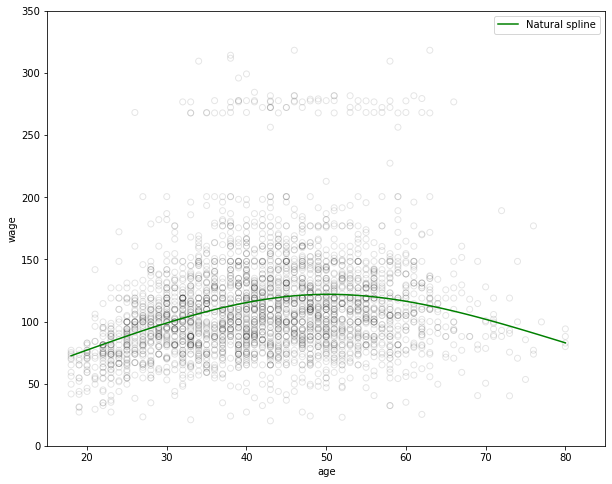

In [14]:
# Generating natural cubic spline
transformed_x3 = dmatrix("cr(train, df=3)", {"train": train_x}, return_type='dataframe')
fit3 = sm.GLM(train_y, transformed_x3).fit()

# Prediction on validation set
pred3 = fit3.predict(dmatrix("cr(valid, df=3)", {"valid": valid_x}, return_type='dataframe'))
# Calculating RMSE value
rms = sqrt(mean_squared_error(valid_y, pred3))
print(rms)

# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred3 = fit3.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))

# Plot the spline
plt.figure(figsize=(10, 8))
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred3,color='g', label='Natural spline')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

## Conclusion

Unlike polynomials, which must use a high degree polynomial to produce flexible fits, regression splines introduce flexibility by increasing the number of knots but keep the degree fixed.

The extra flexibility in the polynomial produces undesirable results at the boundaries, whereas the natural cubic spline still provides a reasonable fit to the data.

---

## Reference

https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/